Evolution of local magnetization after quench in a XXZ chain

In [11]:
import dmrg1 as dmrg1
import tdvp
import MPO_class as MPO
from ncon import ncon

import matplotlib.pyplot as plt
import numpy as np

plt.rc('text',usetex=True)

In [24]:
def compute_local_obs(MPS,op):
    Mtemp = MPS.M.copy()
    L     = len(Mtemp)
    obs   = np.zeros(L) 
    for i in range(0,L):    
        obs[i] = ncon([Mtemp[i],Mtemp[i].conj(),op],[[1,2,3],[1,4,3],[2,4]]).real
        if i != L-1:
            shpM = Mtemp[i].shape
            _,S,V = np.linalg.svd(Mtemp[i].reshape(shpM[0]*shpM[1],shpM[2]), full_matrices = False)
            Mtemp[i+1] = ncon([np.diag(S)@V,Mtemp[i+1]],[[-1,1],[1,-2,-3]])
    return obs

In [5]:
L   = 32
chi = 64

delta   = -0.2
deltaf  = -1.

Hi = MPO.XXZMPO(L, delta,0.)
Hf = MPO.XXZMPO(L, deltaf,0.)

engineDMRG = dmrg1.DMRG1(Hi)
engineDMRG.initialize(chi)

for i in range(20):
    engineDMRG.dmrg_step()

C:\Users\asant\Documents\GitHub\DMRG\LanczosRoutines.py:38: RuntimeWarning: beta[8] ~= 0 encountered during Lanczos iteration.
  warnings.warn(
C:\Users\asant\Documents\GitHub\DMRG\LanczosRoutines.py:38: RuntimeWarning: beta[0] ~= 0 encountered during Lanczos iteration.
  warnings.warn(


In [38]:
engineTDVP = tdvp.TDVP(engineDMRG.MPS, Hf)
engineTDVP.initialize()

dt = 0.01
T  = 20

sigmaz = np.array([[1,0],[0,-1]])
Mz = MPO.getMzMPO(L)

# This should be conserved
mz_tot = np.zeros(int(T/dt)+1)
mz_tot[0] = Mz.contractMPOMPS(engineTDVP.MPS).real

mz_loc = np.zeros((int(T/dt)+1,L))
mz_loc[0,:] = compute_local_obs(engineTDVP.MPS, sigmaz)

for n in range(1,int(T/dt)+1):
    engineTDVP.time_step(dt)
    mz_tot[n] = Mz.contractMPOMPS(engineTDVP.MPS).real
    mz_loc[n,:] = compute_local_obs(engineTDVP.MPS, sigmaz)

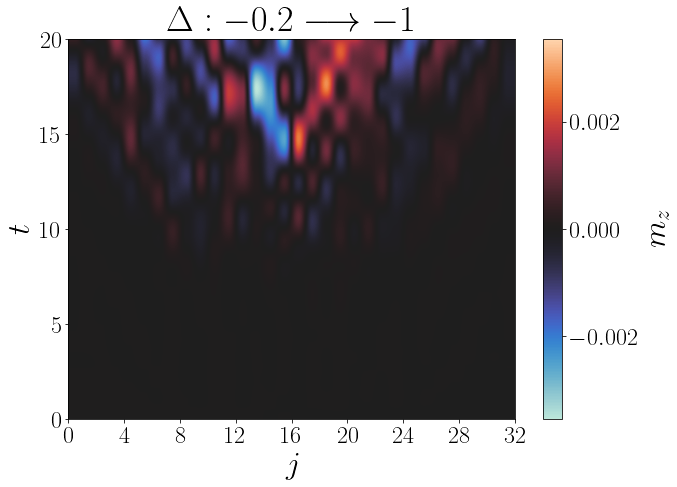

In [121]:
import seaborn as sns
cmap = sns.color_palette('icefire',as_cmap = True)
plt.figure(figsize=(10,7))
plt.title(r"$\Delta: -0.2 \longrightarrow -1$",fontsize=36)
plt.imshow(mz_loc,aspect='auto',origin='lower',extent = [0,L,0,mz_tot.size*dt],cmap = cmap)
lim = np.abs(mz_loc).max()
plt.clim(-lim,lim)
plt.ylabel("$t$",fontsize=32)
plt.xlabel("$j$",fontsize=32)
plt.tick_params(labelsize=24)
plt.xticks(np.arange(0,L+1,4))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=24)
cb.set_label("$m_z$",fontsize=32)
plt.savefig("cmap_local_mag.png",format='png',dpi=400)

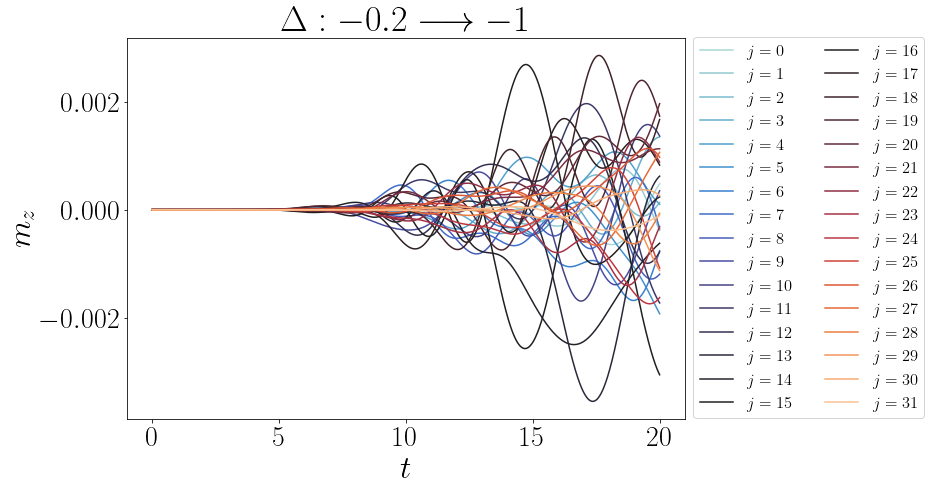

In [120]:
plt.figure(figsize=(10,7))
colors = sns.color_palette('icefire',n_colors=L)
for x in range(L):
    plt.plot(np.arange(0,mz_tot.size)*dt,mz_loc[:,x],color=colors[x],label="$j=%d$"%(x))
plt.tick_params(labelsize=28)
plt.legend(fontsize=16.6, bbox_to_anchor=(1,1.025), ncol=2 )

plt.title(r"$\Delta: -0.2 \longrightarrow -1$",fontsize=36)

plt.xlabel("$t$",fontsize=32)
plt.ylabel("$m_z$",fontsize=32)

plt.savefig("local_mag.png",format='png',dpi=400)


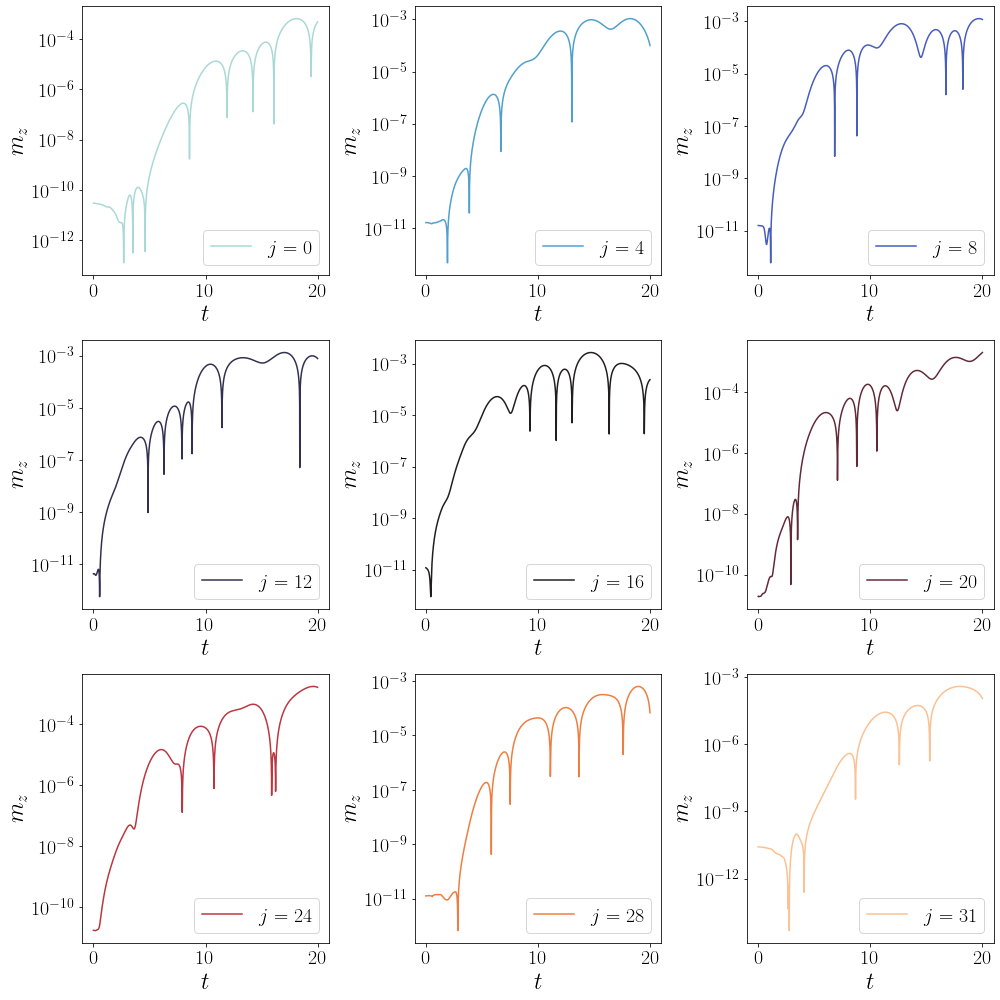

In [122]:
plt.figure(figsize=(14,14))
colors = sns.color_palette('icefire',n_colors=L)

for n,x in enumerate(np.concatenate((np.arange(0,L,L//9+1),np.array([L-1])))):
    plt.subplot(3,3,n+1)
    plt.plot(np.arange(0,mz_tot.size)*dt,np.abs(mz_loc[:,x]),color=colors[x],label="$j=%d$"%(x))
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20,loc='lower right')
    plt.xlabel("$t$",fontsize=24)
    plt.ylabel("$m_z$",fontsize=24)
    plt.yscale('log')

plt.tight_layout()
plt.savefig("log_local_mag.png",format='png',dpi=400)